In [115]:
import numpy as np
import pandas as pd


# Process Datasets

Static features dataset from Matthias, death time series from CSSE, Hospital Data

In [116]:
deaths_t_series = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
deaths_t_series = deaths_t_series.loc[~(deaths_t_series['Lat'] == 0)]
deaths_t_series = deaths_t_series.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', "Combined_Key", "Population"], axis=1)


In [121]:
hospitals = pd.read_csv('../Hospitals.csv')[['TYPE', 'STATUS', 'COUNTYFIPS', 'BEDS']]
static_features = pd.read_csv('../COVID-19_US_County-level_Summaries/data/counties_only.csv')[['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population', 'Percent of adults with less than a high school diploma 2014-18', 'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus', 'POP_ESTIMATE_2018']]
static_features = static_features.dropna()
static_features['pop_density'] = static_features['Density per square mile of land area - Population']
static_features['no_dip'] = static_features['Percent of adults with less than a high school diploma 2014-18']
static_features['elderly_ratio'] = static_features['Total_age65plus']/static_features['POP_ESTIMATE_2018']
static_features['RUCC'] = static_features['Rural-urban_Continuum Code_2013']

In [122]:
hospitals = hospitals[hospitals["STATUS"] == 'OPEN']
hospitals = hospitals[hospitals["TYPE"] == 'GENERAL ACUTE CARE']
hospitals = hospitals[hospitals["BEDS"].astype(str).astype(int) > 0]
hospitals["FIPS"] = hospitals["COUNTYFIPS"]
hospitals = hospitals[hospitals["FIPS"] != 'NOT AVAILABLE']
hospitals = hospitals.drop(["COUNTYFIPS", "STATUS"], axis=1)
hospitals["FIPS"] = hospitals["FIPS"].astype(str).astype(int)
fips_groups = hospitals.groupby("FIPS")

hosp_data = pd.DataFrame(columns=['FIPS', 'HospCt', 'Beds'])
for fips_code, grp in fips_groups:
    hosp_data = hosp_data.append({'FIPS': fips_code, 'HospCt': len(grp), 'Beds': sum(grp["BEDS"])}, ignore_index=True)   

hosp_data.head()

,FIPS,HospCt,Beds
0,1001,1,85
1,1003,3,332
2,1005,1,74
3,1007,1,35
4,1011,1,61


In [119]:
adjacent_counties = pd.read_excel('../adjacent_counties.xlsx', header=None)
adjacent_counties = adjacent_counties[[1, 3]]
adjacent_counties = adjacent_counties[adjacent_counties[1] != adjacent_counties[3]]
pairs = []
for index, row in adjacent_counties.iterrows():
    pair = set([row[1], row[3]])
    if pair not in pairs:
        pairs.append(pair)
np.random.seed(9)
np.random.shuffle(pairs)

In [120]:
print(len(pairs))

9483


## Define helper function for testing features

In [131]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression as logreg

def test_features(features):
    train_x = training_set[features].to_numpy()
    train_y = training_set['More_Deaths'].to_numpy()
    test_x = test_set[features].to_numpy()
    test_y = test_set['More_Deaths'].to_numpy()

    train_x, train_y = shuffle(train_x, train_y, random_state=0)
    test_x, test_y = shuffle(test_x, test_y, random_state=0)
    train_y = np.ravel(train_y)
    test_y = np.ravel(test_y)
    
    print(f'Features: {features}')
    print(f'Test Ratio: {sum(test_y)/len(test_y)}')

    lr = logreg().fit(train_x, train_y)
    print(f'Score: {lr.score(test_x, test_y)}')
    print(f'Coefficients: {lr.coef_}\n')

# 3 Death Thresh, 9 Days Out

In [117]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 9

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh:

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break 

In [118]:
death_data['Deaths'].max()

328.0

Merge Datasets

In [123]:
dataset = hosp_data.merge(death_data, on='FIPS')
dataset = dataset.merge(static_features, on="FIPS")
dataset = dataset.sample(frac=1.0, random_state=9)[['FIPS', 'HospCt', 'Beds', 'Deaths', 'RUCC', 'pop_density', 'no_dip', 'elderly_ratio', 'Unemployment_rate_2018', 'PCTPOV017_2018', 'POP_ESTIMATE_2018']]
dataset.head()

,FIPS,HospCt,Beds,Deaths,RUCC,pop_density,no_dip,elderly_ratio,Unemployment_rate_2018,PCTPOV017_2018,POP_ESTIMATE_2018
54,6113,2,156,8.0,1,197.9,13.6,0.124927,4.2,15.2,220408
412,34017,6,1704,92.0,1,13731.4,15.8,0.118214,3.9,22.3,676061
97,12061,2,486,6.0,3,274.5,11.3,0.330462,4.3,17.9,157413
30,6013,9,1731,7.0,1,1465.2,10.6,0.157747,3.2,9.2,1150215
572,42077,5,1698,8.0,2,1012.5,11.4,0.167093,4.6,17.4,368100


Exclude some outliers

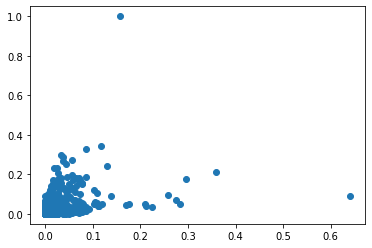

In [124]:
import matplotlib.pyplot as plt

plot_data = dataset.copy()
plot_data['Beds'] = (dataset['Beds'] - np.min(dataset['Beds']))/(np.max(dataset['Beds']) - np.min(dataset['Beds']))
plot_data['Deaths'] = (dataset['Deaths'] - np.min(dataset['Deaths']))/(np.max(dataset['Deaths']) - np.min(dataset['Deaths']))

plot_data = plot_data[plot_data['FIPS'] != 36061]
plot_data = plot_data[plot_data['FIPS'] != 6038]
plot_data = plot_data[plot_data['FIPS'] != 17031]
plot_data = plot_data[plot_data['FIPS'] != 48201]

dataset = dataset[dataset['FIPS'] != 36061]
dataset = dataset[dataset['FIPS'] != 6038]
dataset = dataset[dataset['FIPS'] != 17031]
dataset = dataset[dataset['FIPS'] != 48201]

plt.scatter(plot_data['Deaths'], plot_data['Beds'])

Create the dataset that is to be fed into the classifier: For each pair of counties, take the difference in their features, and also provide an indicator variable identifying which county has more deaths

In [125]:
model_data = pd.DataFrame(columns=['Hosp_diff', 'Beds_diff', 'RUCC_diff', 'dense_diff', 'no_dip_diff', 'elderly_diff', 'unemp_diff', 'pct_pov_diff', 'pop_diff', 'death_diff', 'More_Deaths'])
model_data = model_data.apply(pd.to_numeric) 
dataset.reset_index(drop=True, inplace=True)

for fips1, fips2 in pairs:
    
    row1_df = dataset.loc[dataset["FIPS"] == fips1].reset_index(drop=True)
    row2_df = dataset.loc[dataset["FIPS"] == fips2].reset_index(drop=True)

    if row1_df.empty or row2_df.empty:
        continue
        
    for _, row1 in row1_df.iterrows():
        for _, row2 in row2_df.iterrows():
            if row1['Deaths'] != row2["Deaths"]:

                if row1['Deaths']  > row2["Deaths"]:
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':0}, ignore_index=True)   
                elif row1['Deaths']  < row2["Deaths"]:  
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':1}, ignore_index=True)  





Normalize

In [126]:
model_data = model_data.apply(pd.to_numeric) 

model_data['Hosp_diff'] = (model_data['Hosp_diff'] - np.min(model_data['Hosp_diff']))/(np.max(model_data['Hosp_diff']) - np.min(model_data['Hosp_diff']))

model_data['Beds_diff'] = (model_data['Beds_diff'] - np.min(model_data['Beds_diff']))/(np.max(model_data['Beds_diff']) - np.min(model_data['Beds_diff']))

model_data['dense_diff'] = (model_data['dense_diff'] - np.min(model_data['dense_diff']))/(np.max(model_data['dense_diff']) - np.min(model_data['dense_diff']))

model_data['RUCC_diff'] = (model_data['RUCC_diff'] - np.min(model_data['RUCC_diff']))/(np.max(model_data['RUCC_diff']) - np.min(model_data['RUCC_diff']))

model_data['no_dip_diff'] = (model_data['no_dip_diff'] - np.min(model_data['no_dip_diff']))/(np.max(model_data['no_dip_diff']) - np.min(model_data['no_dip_diff']))

model_data['elderly_diff'] = (model_data['elderly_diff'] - np.min(model_data['elderly_diff']))/(np.max(model_data['elderly_diff']) - np.min(model_data['elderly_diff']))

model_data['unemp_diff'] = (model_data['unemp_diff'] - np.min(model_data['unemp_diff']))/(np.max(model_data['unemp_diff']) - np.min(model_data['unemp_diff']))

model_data['pct_pov_diff'] = (model_data['pct_pov_diff'] - np.min(model_data['pct_pov_diff']))/(np.max(model_data['pct_pov_diff']) - np.min(model_data['pct_pov_diff']))

model_data['death_diff'] = (model_data['death_diff'] - np.min(model_data['death_diff']))/(np.max(model_data['death_diff']) - np.min(model_data['death_diff']))

model_data['pop_diff'] = (model_data['pop_diff'] - np.min(model_data['pop_diff']))/(np.max(model_data['pop_diff']) - np.min(model_data['pop_diff']))

In [127]:
print(len(model_data))

951


In [128]:
model_data = model_data.sample(frac=1, random_state=9)
training_set = model_data.head(750)
test_set = model_data.tail(201)

array([[1.       , 0.3251896],
       [0.3251896, 1.       ]])

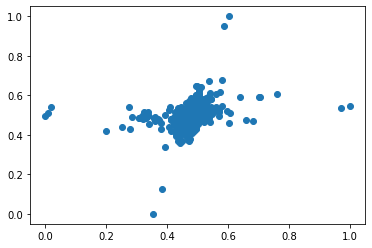

In [129]:
import matplotlib.pyplot as plt

plot_data = pd.concat([training_set, test_set])
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff'])

In [130]:
print(len(training_set))
print(len(test_set))
print(sum(training_set['More_Deaths'])/len(training_set))
print(sum(test_set['More_Deaths'])/len(test_set))

750
201
0.524
0.5024875621890548


In [132]:
test_features(['Hosp_diff'])
test_features(['Beds_diff'])
test_features(['pop_diff'])
test_features(['dense_diff'])
test_features(['RUCC_diff'])
test_features(['Hosp_diff', 'Beds_diff'])
test_features(['pop_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'Beds_diff'])
test_features(['dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Hosp_diff', 'Beds_diff', 'elderly_diff', 'no_dip_diff'])

Features: ['Hosp_diff']
Test Ratio: 0.5024875621890548
Score: 0.5621890547263682
Coefficients: [[-3.20156207]]

Features: ['Beds_diff']
Test Ratio: 0.5024875621890548
Score: 0.6019900497512438
Coefficients: [[-3.85268833]]

Features: ['pop_diff']
Test Ratio: 0.5024875621890548
Score: 0.6119402985074627
Coefficients: [[-3.43012553]]

Features: ['dense_diff']
Test Ratio: 0.5024875621890548
Score: 0.5024875621890548
Coefficients: [[-1.41000554]]

Features: ['RUCC_diff']
Test Ratio: 0.5024875621890548
Score: 0.5771144278606966
Coefficients: [[1.67132296]]

Features: ['Hosp_diff', 'Beds_diff']
Test Ratio: 0.5024875621890548
Score: 0.6218905472636815
Coefficients: [[-2.09654336 -3.18608005]]

Features: ['pop_diff', 'Beds_diff']
Test Ratio: 0.5024875621890548
Score: 0.6417910447761194
Coefficients: [[-2.37860675 -3.10488181]]

Features: ['RUCC_diff', 'Beds_diff']
Test Ratio: 0.5024875621890548
Score: 0.6517412935323383
Coefficients: [[ 1.72361783 -3.92222017]]

Features: ['dense_diff', 'Beds_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[[1.         0.32572301]
 [0.32572301 1.        ]]
[[1.         0.32153891]
 [0.32153891 1.        ]]


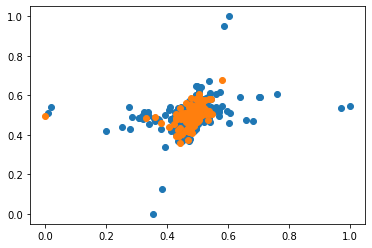

In [133]:
import matplotlib.pyplot as plt

plot_data = training_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

plot_data = test_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

# 3 Deaths Thresh, 21 Days out

In [42]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 21

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh:

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break 

In [67]:
dataset = hosp_data.merge(death_data, on='FIPS')
dataset = dataset.merge(static_features, on="FIPS")
dataset = dataset.sample(frac=1.0, random_state=9)[['FIPS', 'HospCt', 'Beds', 'Deaths', 'RUCC', 'pop_density', 'no_dip', 'elderly_ratio', 'Unemployment_rate_2018', 'PCTPOV017_2018', 'POP_ESTIMATE_2018']]
dataset.head()

,FIPS,HospCt,Beds,Deaths,RUCC,pop_density,no_dip,elderly_ratio,Unemployment_rate_2018,PCTPOV017_2018,POP_ESTIMATE_2018
91,12095,10,3794,21.0,1,1268.5,11.5,0.119379,3.2,22.8,1380645
40,6085,13,3760,43.0,1,1381.0,11.9,0.134772,2.6,7.1,1937570
70,12009,7,1466,8.0,2,535.0,8.0,0.236819,3.5,16.5,596849
106,13015,1,80,27.0,1,217.9,17.0,0.140177,3.8,17.1,106408
97,12109,1,335,4.0,1,316.4,5.4,0.202469,2.9,7.3,254261


Found Some Outliers, Exclude them

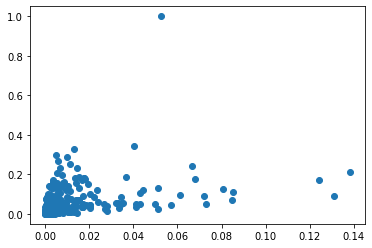

In [68]:
import matplotlib.pyplot as plt

plot_data = dataset.copy()
plot_data['Beds'] = (dataset['Beds'] - np.min(dataset['Beds']))/(np.max(dataset['Beds']) - np.min(dataset['Beds']))
plot_data['Deaths'] = (dataset['Deaths'] - np.min(dataset['Deaths']))/(np.max(dataset['Deaths']) - np.min(dataset['Deaths']))

plot_data = plot_data[plot_data['FIPS'] != 36061]
plot_data = plot_data[plot_data['FIPS'] != 6038]
plot_data = plot_data[plot_data['FIPS'] != 17031]
plot_data = plot_data[plot_data['FIPS'] != 48201]

dataset = dataset[dataset['FIPS'] != 36061]
dataset = dataset[dataset['FIPS'] != 6038]
dataset = dataset[dataset['FIPS'] != 17031]
dataset = dataset[dataset['FIPS'] != 48201]

plt.scatter(plot_data['Deaths'], plot_data['Beds'])

In [75]:
model_data = pd.DataFrame(columns=['Hosp_diff', 'Beds_diff', 'RUCC_diff', 'dense_diff', 'no_dip_diff', 'elderly_diff', 'unemp_diff', 'pct_pov_diff', 'pop_diff', 'death_diff', 'More_Deaths'])
model_data = model_data.apply(pd.to_numeric) 
dataset.reset_index(drop=True, inplace=True)

for fips1, fips2 in pairs:
    
    row1_df = dataset.loc[dataset["FIPS"] == fips1].reset_index(drop=True)
    row2_df = dataset.loc[dataset["FIPS"] == fips2].reset_index(drop=True)

    if row1_df.empty or row2_df.empty:
        continue
        
    for _, row1 in row1_df.iterrows():
        for _, row2 in row2_df.iterrows():
            if row1['Deaths'] != row2["Deaths"]:

                if row1['Deaths']  > row2["Deaths"]:
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':0}, ignore_index=True)   
                elif row1['Deaths']  < row2["Deaths"]:  
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':1}, ignore_index=True)  




In [76]:
model_data = model_data.apply(pd.to_numeric) 

model_data['Hosp_diff'] = (model_data['Hosp_diff'] - np.min(model_data['Hosp_diff']))/(np.max(model_data['Hosp_diff']) - np.min(model_data['Hosp_diff']))

model_data['Beds_diff'] = (model_data['Beds_diff'] - np.min(model_data['Beds_diff']))/(np.max(model_data['Beds_diff']) - np.min(model_data['Beds_diff']))

model_data['dense_diff'] = (model_data['dense_diff'] - np.min(model_data['dense_diff']))/(np.max(model_data['dense_diff']) - np.min(model_data['dense_diff']))

model_data['RUCC_diff'] = (model_data['RUCC_diff'] - np.min(model_data['RUCC_diff']))/(np.max(model_data['RUCC_diff']) - np.min(model_data['RUCC_diff']))

model_data['no_dip_diff'] = (model_data['no_dip_diff'] - np.min(model_data['no_dip_diff']))/(np.max(model_data['no_dip_diff']) - np.min(model_data['no_dip_diff']))

model_data['elderly_diff'] = (model_data['elderly_diff'] - np.min(model_data['elderly_diff']))/(np.max(model_data['elderly_diff']) - np.min(model_data['elderly_diff']))

model_data['unemp_diff'] = (model_data['unemp_diff'] - np.min(model_data['unemp_diff']))/(np.max(model_data['unemp_diff']) - np.min(model_data['unemp_diff']))

model_data['pct_pov_diff'] = (model_data['pct_pov_diff'] - np.min(model_data['pct_pov_diff']))/(np.max(model_data['pct_pov_diff']) - np.min(model_data['pct_pov_diff']))

model_data['death_diff'] = (model_data['death_diff'] - np.min(model_data['death_diff']))/(np.max(model_data['death_diff']) - np.min(model_data['death_diff']))

model_data['pop_diff'] = (model_data['pop_diff'] - np.min(model_data['pop_diff']))/(np.max(model_data['pop_diff']) - np.min(model_data['pop_diff']))

In [77]:
print(len(model_data))

738


In [78]:
model_data = model_data.sample(frac=1, random_state=9)
training_set = model_data.head(550)
test_set = model_data.tail(188)

array([[1.        , 0.48971389],
       [0.48971389, 1.        ]])

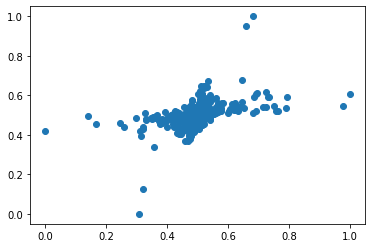

In [79]:
import matplotlib.pyplot as plt

plot_data = pd.concat([training_set, test_set])
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff'])

In [81]:
print(len(training_set))
print(len(test_set))
print(sum(training_set['More_Deaths'])/len(training_set))
print(sum(test_set['More_Deaths'])/len(test_set))

550
188
0.5181818181818182
0.5159574468085106


In [82]:
test_features(['Hosp_diff'])
test_features(['Beds_diff'])
test_features(['pop_diff'])
test_features(['dense_diff'])
test_features(['RUCC_diff'])
test_features(['Hosp_diff', 'Beds_diff'])
test_features(['pop_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'Beds_diff'])
test_features(['dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Hosp_diff', 'Beds_diff', 'elderly_diff', 'no_dip_diff'])

Features: ['Hosp_diff']
Test Ratio: 0.5159574468085106
Score: 0.6329787234042553
Coefficients: [[-2.99912286]]

Features: ['Beds_diff']
Test Ratio: 0.5159574468085106
Score: 0.6968085106382979
Coefficients: [[-3.78483079]]

Features: ['pop_diff']
Test Ratio: 0.5159574468085106
Score: 0.648936170212766
Coefficients: [[-3.42000781]]

Features: ['dense_diff']
Test Ratio: 0.5159574468085106
Score: 0.5797872340425532
Coefficients: [[-2.66291003]]

Features: ['RUCC_diff']
Test Ratio: 0.5159574468085106
Score: 0.5531914893617021
Coefficients: [[2.3423236]]

Features: ['Hosp_diff', 'Beds_diff']
Test Ratio: 0.5159574468085106
Score: 0.6914893617021277
Coefficients: [[-1.94907491 -3.19697773]]

Features: ['pop_diff', 'Beds_diff']
Test Ratio: 0.5159574468085106
Score: 0.7021276595744681
Coefficients: [[-2.4451758  -3.05734337]]

Features: ['RUCC_diff', 'Beds_diff']
Test Ratio: 0.5159574468085106
Score: 0.7180851063829787
Coefficients: [[ 2.44517662 -3.93216768]]

Features: ['dense_diff', 'Beds_di

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[[1.         0.50596625]
 [0.50596625 1.        ]]
[[1.         0.44098508]
 [0.44098508 1.        ]]


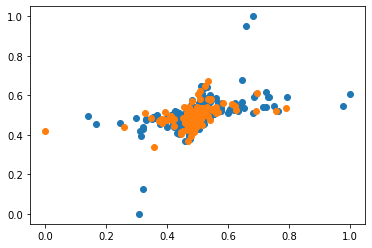

In [83]:
import matplotlib.pyplot as plt

plot_data = training_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

plot_data = test_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

# 3 Deaths Thresh 28 Days out

In [104]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
dates = deaths_t_series.columns[1:]
death_thresh = 3
n_days = 28

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_t_series)):
    county = deaths_t_series.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(dates)):
        if county[dates[j]] >= death_thresh:

            # See if this happened n_days or more before current day
            try:
                n_days_later = dates[j+n_days]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break 

In [105]:
dataset = hosp_data.merge(death_data, on='FIPS')
dataset = dataset.merge(static_features, on="FIPS")
dataset = dataset.sample(frac=1.0, random_state=9)[['FIPS', 'HospCt', 'Beds', 'Deaths', 'RUCC', 'pop_density', 'no_dip', 'elderly_ratio', 'Unemployment_rate_2018', 'PCTPOV017_2018', 'POP_ESTIMATE_2018']]
dataset.head()

,FIPS,HospCt,Beds,Deaths,RUCC,pop_density,no_dip,elderly_ratio,Unemployment_rate_2018,PCTPOV017_2018,POP_ESTIMATE_2018
393,48303,4,1256,43.0,2,311.3,14.2,0.124263,3.1,20.3,307412
228,27037,3,259,11.0,1,709.0,5.1,0.141699,2.5,7.9,425423
371,45085,1,283,11.0,3,161.6,16.4,0.164451,4.0,28.2,106512
345,42017,8,1245,148.0,1,1034.7,6.1,0.186343,3.7,6.6,628195
166,22017,5,1598,93.0,2,290.2,13.4,0.171273,5.5,35.6,242922


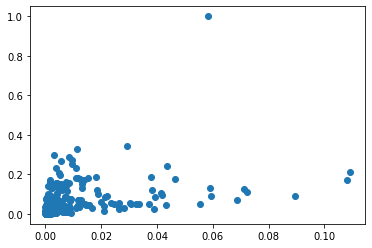

In [106]:
import matplotlib.pyplot as plt

plot_data = dataset.copy()
plot_data['Beds'] = (dataset['Beds'] - np.min(dataset['Beds']))/(np.max(dataset['Beds']) - np.min(dataset['Beds']))
plot_data['Deaths'] = (dataset['Deaths'] - np.min(dataset['Deaths']))/(np.max(dataset['Deaths']) - np.min(dataset['Deaths']))

plot_data = plot_data[plot_data['FIPS'] != 36061]
plot_data = plot_data[plot_data['FIPS'] != 6038]
plot_data = plot_data[plot_data['FIPS'] != 17031]
plot_data = plot_data[plot_data['FIPS'] != 48201]

dataset = dataset[dataset['FIPS'] != 36061]
dataset = dataset[dataset['FIPS'] != 6038]
dataset = dataset[dataset['FIPS'] != 17031]
dataset = dataset[dataset['FIPS'] != 48201]

plt.scatter(plot_data['Deaths'], plot_data['Beds'])

In [107]:
model_data = pd.DataFrame(columns=['Hosp_diff', 'Beds_diff', 'RUCC_diff', 'dense_diff', 'no_dip_diff', 'elderly_diff', 'unemp_diff', 'pct_pov_diff', 'pop_diff', 'death_diff', 'More_Deaths'])
model_data = model_data.apply(pd.to_numeric) 
dataset.reset_index(drop=True, inplace=True)

for fips1, fips2 in pairs:
    
    row1_df = dataset.loc[dataset["FIPS"] == fips1].reset_index(drop=True)
    row2_df = dataset.loc[dataset["FIPS"] == fips2].reset_index(drop=True)

    if row1_df.empty or row2_df.empty:
        continue
        
    for _, row1 in row1_df.iterrows():
        for _, row2 in row2_df.iterrows():
            if row1['Deaths'] != row2["Deaths"]:

                if row1['Deaths']  > row2["Deaths"]:
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':0}, ignore_index=True)   
                elif row1['Deaths']  < row2["Deaths"]:  
                    model_data = model_data.append({'Hosp_diff': int(row1['HospCt']) - int(row2['HospCt']),\
                                                        'Beds_diff': int(row1['Beds']) - int(row2['Beds']),\
                                                        'RUCC_diff': int(row1['RUCC']) - int(row2['RUCC']),\
                                                        'dense_diff':float(row1['pop_density']) - float(row2['pop_density']),\
                                                        'no_dip_diff':float(row1['no_dip']) - float(row2['no_dip']),\
                                                        'elderly_diff': float(row1['elderly_ratio']) - float(row2['elderly_ratio']),\
                                                        'unemp_diff': float(row1['Unemployment_rate_2018']) - float(row2['Unemployment_rate_2018']),\
                                                        'pct_pov_diff': float(row1['PCTPOV017_2018']) - float(row2['PCTPOV017_2018']),\
                                                        'pop_diff' : float(row1['POP_ESTIMATE_2018']) - float(row2['POP_ESTIMATE_2018']),\
                                                        'death_diff' : float(row1['Deaths']) - float(row2['Deaths']),\
                                                        'More_Deaths':1}, ignore_index=True)  





In [108]:
model_data = model_data.apply(pd.to_numeric) 

model_data['Hosp_diff'] = (model_data['Hosp_diff'] - np.min(model_data['Hosp_diff']))/(np.max(model_data['Hosp_diff']) - np.min(model_data['Hosp_diff']))

model_data['Beds_diff'] = (model_data['Beds_diff'] - np.min(model_data['Beds_diff']))/(np.max(model_data['Beds_diff']) - np.min(model_data['Beds_diff']))

model_data['dense_diff'] = (model_data['dense_diff'] - np.min(model_data['dense_diff']))/(np.max(model_data['dense_diff']) - np.min(model_data['dense_diff']))

model_data['RUCC_diff'] = (model_data['RUCC_diff'] - np.min(model_data['RUCC_diff']))/(np.max(model_data['RUCC_diff']) - np.min(model_data['RUCC_diff']))

model_data['no_dip_diff'] = (model_data['no_dip_diff'] - np.min(model_data['no_dip_diff']))/(np.max(model_data['no_dip_diff']) - np.min(model_data['no_dip_diff']))

model_data['elderly_diff'] = (model_data['elderly_diff'] - np.min(model_data['elderly_diff']))/(np.max(model_data['elderly_diff']) - np.min(model_data['elderly_diff']))

model_data['unemp_diff'] = (model_data['unemp_diff'] - np.min(model_data['unemp_diff']))/(np.max(model_data['unemp_diff']) - np.min(model_data['unemp_diff']))

model_data['pct_pov_diff'] = (model_data['pct_pov_diff'] - np.min(model_data['pct_pov_diff']))/(np.max(model_data['pct_pov_diff']) - np.min(model_data['pct_pov_diff']))

model_data['death_diff'] = (model_data['death_diff'] - np.min(model_data['death_diff']))/(np.max(model_data['death_diff']) - np.min(model_data['death_diff']))

model_data['pop_diff'] = (model_data['pop_diff'] - np.min(model_data['pop_diff']))/(np.max(model_data['pop_diff']) - np.min(model_data['pop_diff']))

In [109]:
print(len(model_data))

514


In [110]:
model_data = model_data.sample(frac=1, random_state=9)
training_set = model_data.head(400)
test_set = model_data.tail(114)

array([[1.        , 0.55053791],
       [0.55053791, 1.        ]])

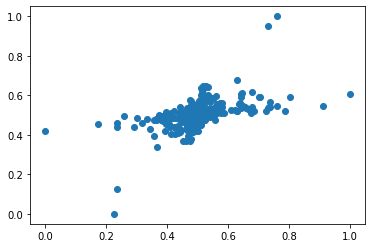

In [111]:
import matplotlib.pyplot as plt

plot_data = pd.concat([training_set, test_set])
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff'])

In [112]:
print(len(training_set))
print(len(test_set))
print(sum(training_set['More_Deaths'])/len(training_set))
print(sum(test_set['More_Deaths'])/len(test_set))

400
114
0.5275
0.49122807017543857


In [113]:
test_features(['Hosp_diff'])
test_features(['Beds_diff'])
test_features(['pop_diff'])
test_features(['dense_diff'])
test_features(['RUCC_diff'])
test_features(['Hosp_diff', 'Beds_diff'])
test_features(['pop_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'Beds_diff'])
test_features(['dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Beds_diff'])
test_features(['RUCC_diff', 'pop_diff', 'dense_diff', 'Hosp_diff', 'Beds_diff', 'elderly_diff', 'no_dip_diff'])

Features: ['Hosp_diff']
Test Ratio: 0.49122807017543857
Score: 0.5701754385964912
Coefficients: [[-2.52442594]]

Features: ['Beds_diff']
Test Ratio: 0.49122807017543857
Score: 0.6403508771929824
Coefficients: [[-3.33412467]]

Features: ['pop_diff']
Test Ratio: 0.49122807017543857
Score: 0.5789473684210527
Coefficients: [[-2.8524214]]

Features: ['dense_diff']
Test Ratio: 0.49122807017543857
Score: 0.5263157894736842
Coefficients: [[-1.85455863]]

Features: ['RUCC_diff']
Test Ratio: 0.49122807017543857
Score: 0.543859649122807
Coefficients: [[1.90642126]]

Features: ['Hosp_diff', 'Beds_diff']
Test Ratio: 0.49122807017543857
Score: 0.6403508771929824
Coefficients: [[-1.61362157 -2.86024086]]

Features: ['pop_diff', 'Beds_diff']
Test Ratio: 0.49122807017543857
Score: 0.6754385964912281
Coefficients: [[-1.99888068 -2.76256756]]

Features: ['RUCC_diff', 'Beds_diff']
Test Ratio: 0.49122807017543857
Score: 0.6666666666666666
Coefficients: [[ 2.09746203 -3.53202763]]

Features: ['dense_diff', 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[[1.         0.55567108]
 [0.55567108 1.        ]]
[[1.         0.54496815]
 [0.54496815 1.        ]]


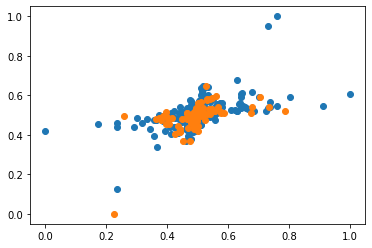

In [114]:
import matplotlib.pyplot as plt

plot_data = training_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))

plot_data = test_set.copy()
plt.scatter(plot_data['death_diff'], plot_data['Beds_diff'])
print(np.corrcoef(plot_data['death_diff'], plot_data['Beds_diff']))